# 4. Advanced TensorFlow/Keras Concepts

This notebook will be a potpourri of several more advanced that couldn't fit into any of the previous notebooks. These will include:

1. A deeper dive into the Keras API.
    - Overview of the repo structure.
    - Discussion on how metrics work.
    - Creating custom components (layers, losses, metrics, etc.)
    - Different ways to build Keras models.
2. Managing multiple devices
    - Distributed training (how to train in more than one GPUs).
    - Explicit device placement (how to specify what op will be done in what device).
3. Model performance optimization.
    - Knowledge distillation.
    - Quantization.
    - Pruning.
    
Since these are more advanced topics, we won't cover them in the same level of detail as the previous. Rather the goal is to provide a point of reference for where to start if you want to delve deeper into one or more of these topics.

In [24]:
import tensorflow as tf
assert tf.__version__[0] == '2', 'this tutorial is for tensorflow versions of 2 or higher'

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Part 1. Deeper dive into Keras API


### Repo structure

Keras has a very well written and clean repo. It is very easy to follow the logic and understand where each component is defined. This might prove useful in cases where we want to understand what a component is exactly doing, or if we want to extend keras with our own custom components. 

Most stuff in the keras repo are neatly organized. For instance inside `keras/losses.py` you would find implementations of all loss functions that base keras supports, in `keras/activations.py` you would find implementations of activaion functions, etc. Some components that have more implementations like layers have a more modular structure. For example to find the implementation of the LSTM layer you would need to look into `keras/layers/rnn/lstm.py`. 

The main stuff we are usually interested in are

Path in Keras repo | Usage
--- | ---
activations.py | Implementation of activation functions
applications/  | Well known NN architectures (e.g. ResNet)
backend.py     | Definitions of lower-level keras objects and ops
callbacks.py   | Implementation of callbacks (e.g. `LearningRateScheduler`)
engine/        | Definition of Keras Model (both Sequential and Functional APIs), training, etc.
initializers/  | Implementation of weight initializers (e.g. `RandomUniform`)
layers/        | Implementation of Keras layers
optimizers/    | Implementation of optimizers (e.g. `SGD`)
preprocessing/ | Various preprocessing functions
utils/         | Lots of commonly used functions (e.g. `to_categorical`)

### Creating custom components

Keras has implementations of most popular choices for each component, but overall it has a quite limited variety. In many cases we want something tailor-made for our application. Defining a custom layer, metric or loss might come in more advanced applications.

We won't go into too much detail, our goal here is to give some starting points where you can explore these concepts in more detail.

- custom layers: [[1]](https://keras.io/guides/making_new_layers_and_models_via_subclassing/), [[2]](https://www.tensorflow.org/tutorials/customization/custom_layers), [[3]](https://towardsdatascience.com/creating-and-training-custom-layers-in-tensorflow-2-6382292f48c2)
- custom metrics: [[1]](https://keras.io/api/metrics/#creating-custom-metrics), [[2]](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Metric), [[3]](https://stackoverflow.com/questions/37657260/how-to-implement-custom-metric-in-keras)
- custom losses: [[1]](https://keras.io/api/losses/#creating-custom-losses), [[2]](https://stackoverflow.com/questions/43818584/custom-loss-function-in-keras), [[3]](https://stackoverflow.com/questions/45961428/make-a-custom-loss-function-in-keras)
- obviously you can define any other custom component you want (activation, intiializer, optimizer, model, etc.). These are less frequent and you'll have to look them up on your own :)

### Understanding Keras metrics

Keras metrics have some details that might confuse us when trying to use or interpret them. The main difference is that unlike losses, metrics are **stateful**. This means that they have some notion of internal state (this is usually a moving average of their previous values), which is **updated** every time we call them. 

The proper way to interact with keras metrics is through their `update_state()` and `result()` methods, which update their state and return the computed value at the given state. We'll simulate a training epoch as an example to better illustrate how metrics operate.

In [98]:
# You can ignore this cell if you want, we just create some dummy data for y and y_hat

num_iters = 500
num_samples = 32


y = np.random.choice(2, size=(num_iters, num_samples))  # 100 iterations, 20 examples


# Number of mistakes per iteration
num_errors = (np.floor(np.arange(num_iters) // (num_samples // 2))[::-1] +
              np.random.randint((num_samples // 4), size=num_iters)).astype(int) 


def swap_zeros_with_ones(arr_slice):
    '''
    Helper function that swaps 0 --> 1 and vice versa
    '''
    return np.where((arr_slice==0)|(arr_slice==1), arr_slice^1, arr_slice)


y_hat = y.copy()


for i in range(num_iters):
    index_to_swap = np.random.permutation(num_samples)[:num_errors[i]]
    y_hat[i, index_to_swap] = swap_zeros_with_ones(y_hat[i, index_to_swap])

Let's plot how the accuracy would look like per batch if we were using a conventional scikit-learn metric.

Text(0, 0.5, 'Accuracy')

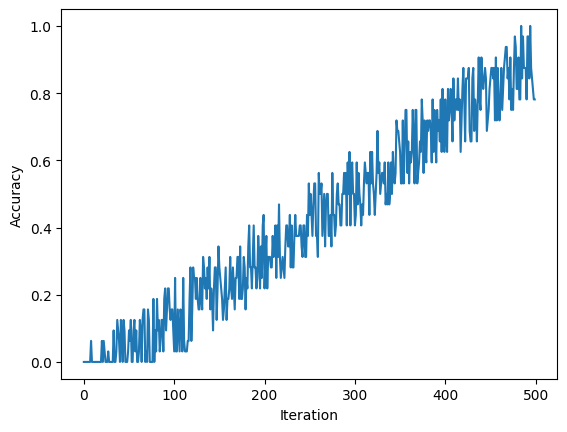

In [99]:
from sklearn.metrics import accuracy_score

accs = [accuracy_score(y_it, y_hat_it) for y_it, y_hat_it in zip(y, y_hat)]

plt.plot(accs)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

As we can see accuracy has a slightly improving trend, but it is very noisy. This may be slightly exagerated in the example I created but it's not very unrealistic, as evaluating a metric like accuracy on a batch level (with a relatively small batch size) is inherently very noisy.

To deal with this, Keras' accuracy by default keeps track of the **moving average** of the individual accuracies of each batch.

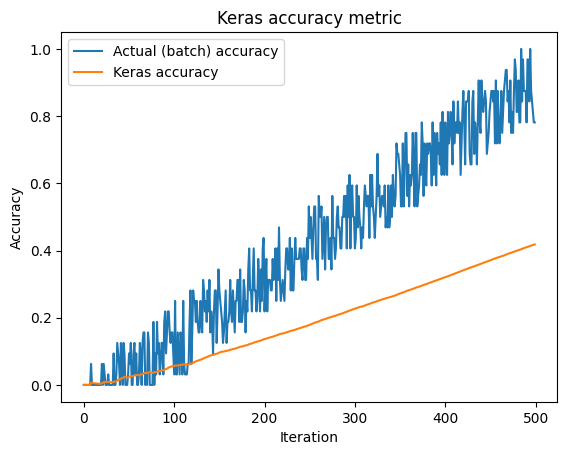

In [102]:
accuracy = tf.keras.metrics.Accuracy()
accs_keras = []

# Let's say this is the training loop and at each iteration we update the state
# of our metrics, as well as getting the result of our moving-averaged metric
for y_it, y_hat_it in zip(y, y_hat):
    accuracy.update_state(y_it, y_hat_it)
    accs_keras.append(accuracy.result())
    

plt.plot(accs, label='Actual (batch) accuracy')
plt.plot(accs_keras, label='Keras accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Keras accuracy metric')
plt.legend()

First of all, the accuracy is much smoother due to the moving average nature of the metric. However, because our example was relatively extreme (it pushed from 0% to 100% accuracy within 500 iterations), the moving average was **much slower to catchup**. This happens because results during the end of the epoch are dragged down by the initial iterations. 

This is a phenomenon that actually happens in Keras and we need to be aware of it!

A few more things to note:
- Unlime metrics, all losses in Keras are **stateless**.
- There are also **stateless** Keras metrics, however the most common ones (e.g. accuracy) are by default steteful.
- During training, **the state gets reset at the end of each epoch**. This means that we can see a notable jump in performance from one epoch to another.
- Likewise we might see better validation performance than training performance during the end of each epoch. The reason is the same: while the training metric is dragged down by previous iterations (which had less trained versions of the model), the validation is all done on the last updated model, which is generally stronger.

### Other ways to create Keras models

During these two courses we've only seen one way to create keras models, i.e. through the `tf.keras.models.Model` class. This is referred to as the **Functional API**, because we define layers as functions of one another:

```python
layer1 = Input(...)
layer2 = Dense(...)(layer1)
layer3 = Dense(...)(layer2)
# etc.
```

There are also two other ways of creating keras models. 

The first is the [**Sequential API**](https://keras.io/api/models/sequential/), which we briefly touched in the 
first notebook of TF101. While this is arguably slightly simpler to setup, it is much more limiting in what we can do with it than the Functional API. Due to this, I elected not to focus at all on this API.

An example of how this looks like (taken from the [Keras docs](https://keras.io/guides/sequential_model/)

```python
model = keras.Sequential(
    [
        layers.Dense(2, activation="relu", name="layer1"),
        layers.Dense(3, activation="relu", name="layer2"),
        layers.Dense(4, name="layer3"),
    ]
)
```

The second way is by **subclassing the Model class**. This is a more object-oriented way of creating keras Models and it gives us an even greater degree of flexibility when creating these models. One example is that it allows us to dynamically create the model's graph depending on the input.

An example of how this looks like (taken from the [Keras docs](https://keras.io/api/models/model/#model-class)

```python
class MyModel(tf.keras.Model):

    def __init__(self):
        super().__init__()
        self.dense1 = tf.keras.layers.Dense(4, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(5, activation=tf.nn.softmax)
        self.dropout = tf.keras.layers.Dropout(0.5)

    def call(self, inputs, training=False):
        x = self.dense1(inputs)
        if training:
            x = self.dropout(x, training=training)
        return self.dense2(x)

model = MyModel()
```

## Part 2. Managing multiple devices

In more large scale environments we might even have access to more than 1 GPUs that can either be located on the same host or on differenct hosts, connected via the network.

### Distributed training

What we want to do here is to find a way to distribute computation across multiple devices. There are genrally to ways to do achieve this:

- **Data parallelism**: these strategies replicate a single model across multiple devices. Each of them is trained on different batches of data and then the models are aggregated together. Data paralellism can either be synchronous or asynchronous.

- **Model parallelism**: in these strategies the model is segmented into parts that each runs on a different device. This allows for training larger models, as they do not need to fit in memory. These strategies work best with models that have a naturally-parallel architecture, such as models that feature multiple branches.

The most common of the two is model parallelism. This can be done with the help of the [`tf.distribute`](https://www.tensorflow.org/api_docs/python/tf/distribute) API. 

The most popular example is the `tf.distribute.MirroredStrategy` which is a synchronous data paralellism strategy that works if all devices are on the same host. It creates replicas of the model in each device and trains each, synchronously, on different batches of the input.

```python
strategy = tf.distribute.MirroredStrategy(['GPU:0', 'GPU:1'])  # leave empty for all devices
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# Open a strategy scope.
with strategy.scope():
    # Everything that creates variables should be under the strategy scope.
    # In general this is only model construction & `compile()`.
    model = Model(...)
    model.compile(...)

# Train the model on all available devices.
model.fit(train_dataset, validation_data=val_dataset, ...)

# Test the model on all available devices.
model.evaluate(test_dataset)
```

These guides provide more detail into how different distribution strategies are configures: [[1]](https://keras.io/guides/distributed_training/), [[2]](https://www.tensorflow.org/guide/distributed_training). 

### Explicit device placement

This is a way of explicitly placing parts of the model on specific devices (which is one way to implement model paralellism).

```python
with tf.device('GPU:0'): # Or GPU:1 for the 2nd GPU, GPU:2 for the 3rd etc.
    a = tf.random.uniform([1000, 1000])
    b = tf.random.uniform([1000, 1000])
    
    c = tf.matmul(a. b)
```

## Part 3. Model performance optimization

We delved a bit into optimizing the data pipeline in the previous notebook, but we haven't touched about model performance. Keep in mind that this doesn't necessarily have to do with training the model; most optimizations target the **deployment** of the model (i.e. the model that is in production, serving requests). Optimization in these terms might have to do with **reducing the memory footprint** of the model, **reducing its latency**, etc.

These are more advanced topics and as with the previous parts, we won't go into detail regarding these. Our goal is to showcase some techniques that can be used and provide resources for further reading.

#### Knowledge distillation

Knowledge Distillation (KD) is a modelling technique that can be used to **compress** a large model (commonly called a *teacher*) into a smaller one (a *student*), while retaining most of its predictive power. 

Let's say we have our two NNs: the large Teacher $T$ and the small student $S$.

The teacher is trained on a large dataset $(X, y)$, normally, using cross-entropy:

$$
L_T = - \sum_{i=1}^N{y \log{\hat y_T}}
$$

Our teacher is a very strong model that achieves very high scores on our metrics. Unfortunately, it is too large to actually deploy, so we need to compress it through KD. For this reason we will train our student on the same data, with the following way:

$$
L_S = - \sum_{i=1}^N{\left( (1-a) \cdot y \log{\hat y_S} + a \cdot y_T \log{\hat y_S} \right)}
$$

The second term is essentially another cross-entropy term that tries to **bring our student's predictions closer to those of our teacher**! A hyperparameter $a$ controlls the strength of KD (higher values mean more influence from the teacher rather than the actual labels).

Among other things this method has been proven very effective at model compression. An example of this is [DistillBERT](https://arxiv.org/abs/1910.01108), a Transformer trained using KD from [BERT](https://arxiv.org/abs/1810.04805), that is $40\%$ smaller (and $60\%$ faster) while retaining $97\%$ of its natural language capabilities!

#### Weight quantization

Weight quantization referrs to the practice of **reducing the precision of a network's weights** (e.g. to 16-bit floats). This can result to a significant reduction in model size (i.e. going from 32-bits to 8-bits will reduce the memory footprint of your model by 4x) and much faster inference speeds. Additionally, for some types of hardware require such low precisions, which makes such a technique mandatory if we want to deploy our model on these environments. 

There are two types of quantizations, both fully supported by TensorFlow:

- Post-training quantization: [[1]](https://blog.tensorflow.org/2018/09/introducing-model-optimization-toolkit.html?_gl=1*30lv82*_ga*NzIwMzY5MDcuMTY4MjY2NTU4MQ..*_ga_W0YLR4190T*MTY4MjY2NTU4MS4xLjEuMTY4MjY2NTc1NC4wLjAuMA..), [[2]](https://www.tensorflow.org/model_optimization/guide/quantization/post_training)
- Quantization-aware training: [[1]](https://www.tensorflow.org/model_optimization/guide/quantization/training), [[2]](https://www.tensorflow.org/model_optimization/guide/quantization/training_example), [[3]](https://www.tensorflow.org/model_optimization/guide/quantization/training_comprehensive_guide)

#### Weight pruning

Weight pruning is a technique that aims at **removing certain connections between neurons**, thus trimming the **parameters** and **operations** from the network. This can significantly reduce the **size** of a network (even up to 90%) and also improve latency. 

This usually involves removing weights with **values close to zero** (i.e. that aren't involved much in the overall computation). Usually this is done **during training** to let the network adapt to the changes.

Resources: [[1]](https://blog.tensorflow.org/2019/05/tf-model-optimization-toolkit-pruning-API.html?_gl=1*1fuu4r5*_ga*NzIwMzY5MDcuMTY4MjY2NTU4MQ..*_ga_W0YLR4190T*MTY4MjY2NTU4MS4xLjEuMTY4MjY2NTY3My4wLjAuMA..), [[2]](https://www.tensorflow.org/model_optimization/guide/pruning)

#### Weight clustering

Weight clustering or **weight sharing** is a technique where we group individual weight values within a layer into different clusters, through the use of a clustering algorithm (like k-means) and the weights within each group are all represented by a single value. During training the respective gradients for the weights of each weight group are aggregated into a single value which is used to update the shared weight. More details about this process can be found [here](https://arxiv.org/pdf/1510.00149.pdf) (see Sec. 3).

Resources: [[1]](https://www.tensorflow.org/model_optimization/guide/clustering), [[2]](https://www.tensorflow.org/model_optimization/guide/clustering/clustering_example), [[3]](https://www.tensorflow.org/model_optimization/guide/clustering/clustering_comprehensive_guide).

## Closing remarks

These two tutorials were created as of 28/4/2023. Unfortunately due to lack of resources, maintenence of this tutorial will be minimal. TensorFlow is a fast-evolving framework, so stuff mentioned might become deprecated in the future, or new and simpler APIs might spawn up. It might be helpful to go through the official documentation on your own to identify such instances. 

Hope you found these tutorials useful :)